In [1]:
!nvidia-smi

Wed Nov  6 15:32:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install tensorflow==2.13.0

In [3]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

!pip install -U albumentations

Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libavcodec-9aae324f.so.59.37.100
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libavformat-3ff1be5b.so.59.27.100
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libavutil-a0a0531e.so.57.28.100
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libcrypto-337dac8b.so.1.1
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.10/dist-packages/opencv_python_headless.libs/libpng16-1bde1c40.so.16.43.0
    /usr/local/li

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [7]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/'

import os

BASE_DIR = os.getcwd()

# BASE_DIR is working directory for this notebook
print(BASE_DIR)

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive


## Import libraries

In [9]:
import string
import json
import numpy as np
import matplotlib.pyplot as plt

from htr.preprocessing import get_augmentation_pipeline
from htr.generator import DataGenerator
from htr.network.models import *
from htr.utils import implt

from htr.evaluation import ocr_metrics

from tensorflow.keras.models import Model

# Load the TensorBoard notebook extension
%load_ext tensorboard

***Filepaths***

In [10]:
dataset_path = os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting1.hdf5')

***Parameters***

In [11]:
input_size = (256, 64, 1)
max_text_len = 32
batch_size = 32
epochs = 200

# charset = ''.join(json.load(open(os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting-characters.json'))))

charlist = json.load(open(os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting-characters.json')))
charlist.remove(' ')
charset = ''.join(charlist)
print(len(charset))

90


***DataGenerator class***

In [ ]:
generator = DataGenerator(dataset_path=dataset_path,
                          input_size=input_size,
                          batch_size=batch_size,
                          max_text_len=max_text_len,
                          charset=charset,
                          aug= get_augmentation_pipeline(),
                          encoding='utf-8')

print('Images:', generator._size)

## *Custom*
### Model
***Based on model.py***

In [14]:
import tensorflow as tf

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import MaxNorm

from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM, GRU, Dense
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, PReLU, Dropout
from tensorflow.keras.layers import MaxPooling2D, Input, Reshape, MaxPool2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import ReLU, concatenate

from htr.network.layers import FullGatedConv2D, GatedConv2D

In [15]:
def custom4(input_size, d_model):
    input_data = Input(name="input", shape=input_size)

    cnn = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(input_data)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=16, kernel_size=(3, 3), padding="same")(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=32, kernel_size=(3, 3), padding="same")(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)

    cnn = Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=48, kernel_size=(3, 3), padding="same")(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    cnn = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform")(cnn)
    cnn = PReLU(shared_axes=[1, 2])(cnn)
    cnn = BatchNormalization(renorm=True)(cnn)
    cnn = FullGatedConv2D(filters=64, kernel_size=(3, 3), padding="same")(cnn)
    cnn = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")(cnn)
    cnn = Dropout(rate=0.2)(cnn)

    shape = cnn.get_shape()
    blstm = Reshape((shape[1], shape[2] * shape[3]))(cnn)

    blstm = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5))(blstm)
    blstm = Dense(units=256)(blstm)

    blstm = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5))(blstm)
    output_data = Dense(units=d_model, activation="softmax")(blstm)

    return (input_data, output_data)


In [16]:
output_path = os.path.join(BASE_DIR, 'htr', 'data3', 'output-bangla-custom4')
target_path = os.path.join(output_path, 'checkpoint_weights.hdf5')

In [ ]:
inputs, outputs = custom4(input_size=input_size, d_model=generator.tokenizer.vocab_size + 1)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ctc_loss)

# Load weights from target_path
if os.path.isfile(target_path):
    model.load_weights(target_path)
    print('===== Pre-trained weights loaded =====')

### Training

In [ ]:
callbacks = get_callbacks(logdir=output_path,
                          checkpoint_filepath=target_path,
                          verbose=1,
                          stop_patience=15,
                          reduce_patience=4)

In [ ]:
model.fit(x=generator.next_train_batch(),
          steps_per_epoch=generator._steps['train'],
          validation_data=generator.next_val_batch(),
          validation_steps=generator._steps['val'],
          epochs=epochs,
          callbacks=callbacks,
          verbose=1)

*Training history from CSVLogger callback*

Min val_loss: 1.8744866847991943
Min val_loss epoch: 127


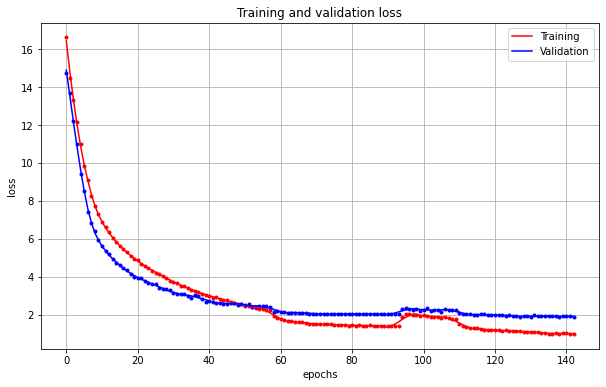

In [ ]:
from pandas import read_csv
from scipy.signal import savgol_filter
from ipywidgets import interact

path = os.path.join(output_path, 'epochs.log')
if os.path.isfile(path):
    history = read_csv(path)
    loss = history['loss']
    val_loss = history['val_loss']

    print('Min val_loss:', np.min(val_loss))
    print('Min val_loss epoch:', np.argmin(val_loss))

    # Plot training vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss, 'r.')
    plt.plot(val_loss, 'b.')
    # Smoothing
    plt.plot(savgol_filter(loss, 11, 3), 'r-', label='Training')
    plt.plot(savgol_filter(val_loss, 11, 3), 'b-', label='Validation')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid('on')
    plt.show()

else:
    print("File doesn't exist")

*Logs from Tensorboard*

If tensorboard gets timed out or doesn't show up, it might be running on http://localhost:6006/.

In [ ]:
!find /content/drive/My\Drive/htr/data/output-bangla-puigcerver | grep tfevents

In [ ]:
%tensorboard --logdir /content/drive/My\Drive/htr/data/output-bangla-puigcerver

### Prediction | Evaluation

***Validation set***

In [ ]:
print('           VALIDATION SET           ')
Y_pred = model.predict(x=generator.next_val_batch(), steps=generator._steps['val'], verbose=1)
print('Y_pred shape:', Y_pred.shape)

# Predictions, Probabilities after decoding
predictions, probabilities = ctc_decode(Y_pred=Y_pred, batch_size=batch_size, verbose=1)
print('\nCTC decoded predictions len:', len(predictions))

pred_texts = [generator.tokenizer.decode(y) for y in predictions]
gt_texts = [y.decode() for y in generator.dataset['val']['gt_texts']]

cer, wer, ser = ocr_metrics(pred_texts, gt_texts, lower=False) * 100
print(f'Character Error Rate (%) : {cer:.4f}')
print(f'Word Error Rate (%) : {wer:.4f}')
print(f'Sequence Error Rate (%) : {ser:.4f}')

           VALIDATION SET           
26/26 [==============================] - 4s 66ms/step
Y_pred shape: (829, 16, 93)
26/26 [==============================] - 10s 373ms/step

CTC decoded predictions len: 829
Character Error Rate (%) : 12.7807
Word Error Rate (%) : 36.6707
Sequence Error Rate (%) : 36.6707


***Test set***

In [ ]:
print('           TEST SET           ')
Y_pred = model.predict(x=generator.next_test_batch(), steps=generator._steps['test'], verbose=1)
print('Y_pred shape:', Y_pred.shape)

# Predictions, Probabilities after decoding
predictions, probabilities = ctc_decode(Y_pred=Y_pred, batch_size=batch_size, verbose=1)
print('\nCTC decoded predictions len:', len(predictions))

pred_texts = [generator.tokenizer.decode(y) for y in predictions]
gt_texts = [y.decode() for y in generator.dataset['test']['gt_texts']]

cer, wer, ser = ocr_metrics(pred_texts, gt_texts, lower=False) * 100
print(f'Character Error Rate (%) : {cer:.4f}')
print(f'Word Error Rate (%) : {wer:.4f}')
print(f'Sequence Error Rate (%) : {ser:.4f}')

           TEST SET           
39/39 [==============================] - 5s 66ms/step
Y_pred shape: (1244, 16, 93)
39/39 [==============================] - 15s 373ms/step

CTC decoded predictions len: 1244
Character Error Rate (%) : 12.3678
Word Error Rate (%) : 34.1640
Sequence Error Rate (%) : 34.1640
